<div style="background-color:#e8f4fd; padding:1em; border-radius:6px;">
<b>Notebook Disclaimer</b><br><br>
This notebook is part of the supporting material for the paper:<br>
<i>Modeling soil organic carbon changes using signal-to-noise analysis: a case study using European soil survey datasets.</i><br><br>
The figure and accompanying text are designed to be self-explanatory — you shouldn’t need to dive into the code to get the point :)<br>
But if you are curious about the implementation details, feel free to check the code blocks, too.
</div>



# LUCAS SOC Temporal Variability

This notebook presents the results of an analysis of the temporal variability in soil organic carbon (SOC) based on repeated measurements from the LUCAS dataset.


In [1]:
# Import necessary data
version = 'v20250521'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

point = pd.read_parquet(f'./material/soc.topsoil_organized_{version}.pq')
srs = pd.read_parquet(f'./material/srs_lucas.plausible_{version}.pq')
print(f'in total {len(srs)} time series with 3 observations (\u03B2)')
pair = pd.read_parquet(f'./material/pair_lucas.plausible_{version}.pq')
print(f'in total {len(pair)} paired observations (\u03B4)')
pair['soc_change'] = pair['soc_pair'].str[1] - pair['soc_pair'].str[0]

in total 10204 time series with 3 observations (β)
in total 30612 paired observations (δ)


## $\delta$ Analysis

### Distribution by Year Interval

We analyzed the distribution of $\delta$ values calculated from repeated LUCAS SOC measurements taken at different time intervals (3, 6, and 9 years).  
The following patterns were identified:

1. **Small SOC change**  
   Most $\delta$ values (g/kg) from repeated LUCAS measurements cluster around zero, regardless of the sampling interval length. This reflects the inherently slow-changing nature of SOC.

2. **Extreme outliers**  
   Across all intervals, several extreme—and in some cases likely unrealistic—$\delta$ values were observed (e.g., >30 g/kg in less than 10 years, with some exceeding 100 g/kg).  
   Possible explanations for these anomalies are discussed in Section 4.5 of the paper. In summary, they may result from inconsistent removal of litter layers or spatial shifts in sampling locations rather than genuine temporal changes in SOC.

3. **High background noise level**  
   When comparing the $\delta$ distributions across the three time intervals, no clear differences emerge.  
   Although one might expect longer intervals to allow for larger cumulative SOC changes (and thus broader distributions), this pattern is not evident in the data.  
   This likely reflects a high background noise level, which may also explain the low signal-to-noise ratio observed in the model results.



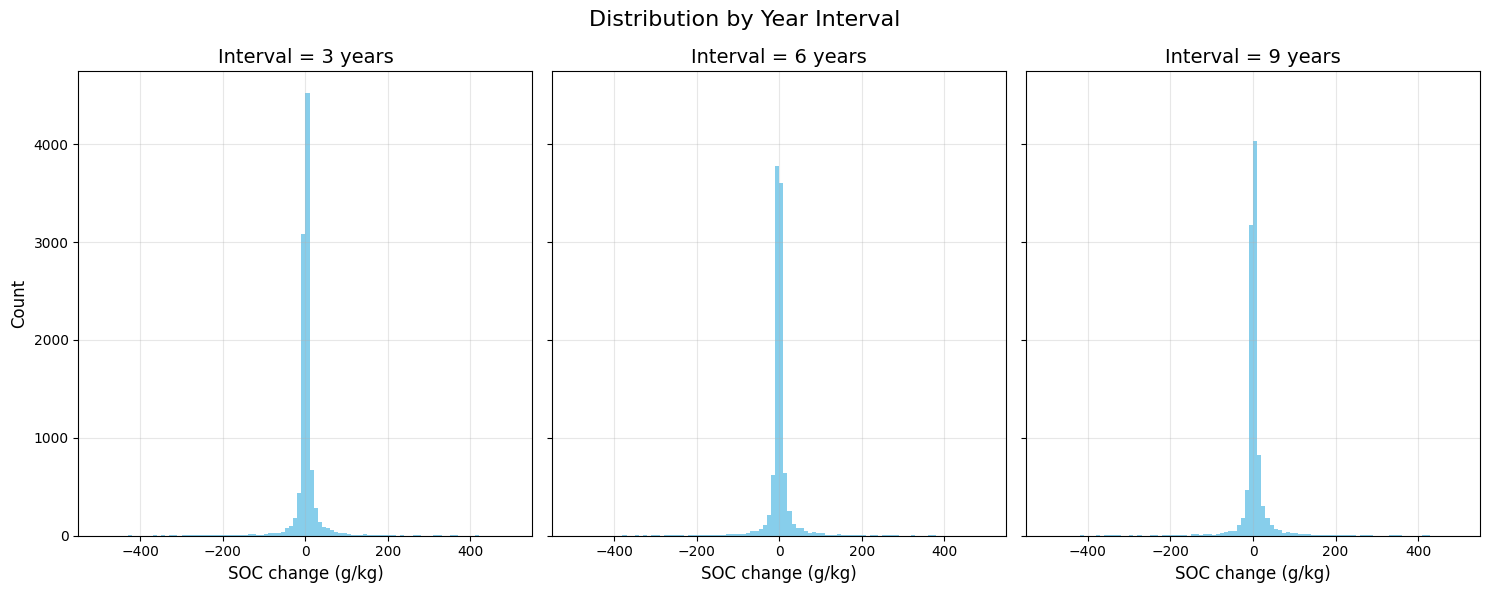

In [2]:
pair['interval'] = pair['time_pair'].str[1] - pair['time_pair'].str[0]
intervals = sorted(pair['interval'].unique())

# Create subplots: one per interval
fig, axes = plt.subplots(1, len(intervals), figsize=(15, 6), sharey=True)

for ax, interval in zip(axes, intervals):
    subset = pair[pair['interval'] == interval]
    ax.hist(subset['soc_change'], bins=100, range=[-500,500], color='skyblue')
    ax.set_title(f'Interval = {interval} years', fontsize=14)
    ax.set_xlabel('SOC change (g/kg)', fontsize=12)
    ax.grid(alpha=0.3)

axes[0].set_ylabel('Count', fontsize=12)
fig.suptitle("Distribution by Year Interval", fontsize=16)
plt.tight_layout()
plt.show()

### Distribution by Land Cover

Management practices are known to influence SOC dynamics. Unfortunately, detailed management or activity data are not available for the LUCAS sites. However, the LUCAS land cover classes can serve as a meaningful proxy for vegetation-driven processes and organic carbon inputs.  

In this analysis, land cover classes series of sampling years were used to approximate the influence of land use and management on SOC variability.


The land cover classes are represented by the first letter in each series (e.g., cropland–cropland → **CC**).

1. **Small SOC change**  
   As identified previously, most $\delta$ values cluster around zero across all land cover classes.

2. **No evident skewness in most land cover series**  
   For most land cover transitions, the $\delta$ distributions are approximately symmetric around zero, showing no clear positive or negative skewness.  
   This indicates that, overall, no substantial SOC changes were detected within these land cover types.

3. **Slight positive skewness in high-vegetation-related classes**  
   Land cover transitions involving grassland (G), shrubland (S), or woodland (W) tend to show slightly positive skewness.  
   This includes:
   - Unchanged classes: **WW**, **SS**  
   - Decreasing vegetation cover: **WG**  
   - Increasing vegetation cover: **CG**, **SW**, **GW**  

   Among these, transitions involving woodland generally show the largest (though still small) SOC changes.  
   Two potential explanations are:  
   1. Greater vegetation cover is associated with higher organic carbon input, potentially contributing to SOC increases.  
   2. In woodland areas, the inclusion of litter layers during sampling may artificially raise SOC measurements.  

   Without more detailed information or further analysis, it is difficult to determine the dominant cause.

**Overall**, no clear negative skewness was observed across any land cover transitions.

In [3]:
pair['lc_str'] = pair['lc_survey_pair'].str[0] + '-' + pair['lc_survey_pair'].str[1]
# l1 = pair['lc_str'].unique().tolist()
# l2 = [ii.replace('land','') for ii in l1]
# map_l = dict(zip(l1,l2))
# pair['lc_str'] = pair['lc_str'].map(map_l)

# only examine land cover series with population>30
vc = pair['lc_str'].value_counts()
lcl = vc[vc>30].index.tolist() 
pair = pair.loc[pair['lc_str'].isin(lcl)]

print(f'This analysis is only done on land covers with more than 30 records, they are')
print(lcl)

# plot in order
lc_order = [
    'cropland-cropland','grassland-grassland','woodland-woodland','shrubland-shrubland',
    'cropland-bareland','grassland-cropland','woodland-grassland',
    'bareland-cropland','cropland-grassland','shrubland-woodland','grassland-woodland'
]

# Set lc_str as categorical with the desired order
pair['lc_str'] = pd.Categorical(pair['lc_str'], categories=lc_order, ordered=True)

import matplotlib.patches as mpatches

# Define land cover change groups
no_change = ['cropland-cropland','grassland-grassland','woodland-woodland','shrubland-shrubland']
decreasing = ['cropland-bareland','grassland-cropland','woodland-grassland']
increasing = ['bareland-cropland','cropland-grassland','shrubland-woodland','grassland-woodland']

# Map lc_str to colors
color_map = {}
for lc in lc_order:
    if lc in no_change:
        color_map[lc] = 'olive'
    elif lc in decreasing:
        color_map[lc] = 'brown'
    elif lc in increasing:
        color_map[lc] = 'green'
    else:
        color_map[lc] = 'gray'  # fallback color

This analysis is only done on land covers with more than 30 records, they are
['cropland-cropland', 'woodland-woodland', 'grassland-grassland', 'cropland-grassland', 'grassland-cropland', 'cropland-bareland', 'bareland-cropland', 'shrubland-shrubland', 'grassland-woodland', 'woodland-grassland', 'shrubland-woodland', 'grassland-shrubland', 'bareland-bareland', 'bareland-grassland', 'woodland-shrubland', 'grassland-bareland', 'shrubland-grassland', 'cropland-woodland', 'bareland-woodland', 'wetland-wetland', 'woodland-cropland']


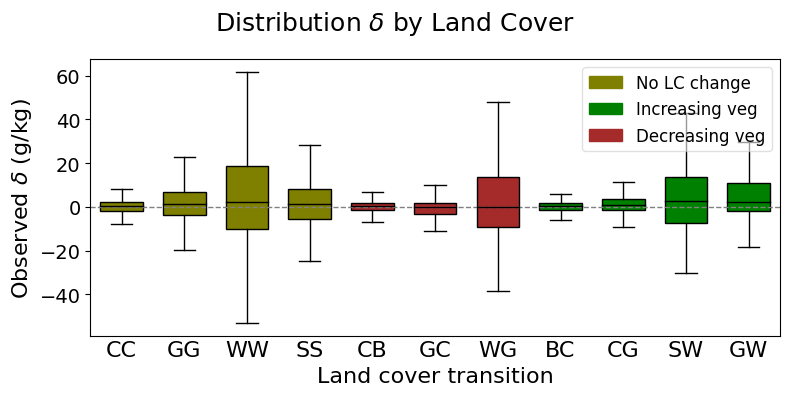

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))

x = np.arange(len(lc_order))
bar_width = 0.34

signal_data = [pair.loc[pair['lc_str'] == lc, 'soc_change'].dropna() for lc in lc_order]
bp = ax.boxplot(
    signal_data,
    positions=x,
    widths=bar_width * 2,
    showfliers=False,
    patch_artist=True,
    medianprops=dict(color='black')
)

# corlor land cover group
for box, lc in zip(bp['boxes'], lc_order):
    box.set_facecolor(color_map[lc])
    box.set_edgecolor('black')

# x label
ax.set_ylabel(r'Observed $\delta$ (g/kg)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)

# x tick label
ax.set_xticks(x)
ax.set_xticklabels(['CC','GG','WW','SS','CB','GC','WG','BC','CG','SW','GW'],rotation=0, ha='center', fontsize=16)
ax.tick_params(axis='x', which='both', length=0)
ax.set_xlabel(r'Land cover transition', fontsize=16)

# 0 line
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# lc change group
olive_patch = mpatches.Patch(color='olive', label='No LC change')
green_patch = mpatches.Patch(color='green', label='Increasing veg')
brown_patch = mpatches.Patch(color='brown', label='Decreasing veg')

ax.legend(handles=[olive_patch, green_patch, brown_patch],
          fontsize=12, framealpha=0.6, loc='upper right')
fig.suptitle("Distribution $\delta$ by Land Cover", fontsize=18)
plt.tight_layout()
plt.show()


## $\beta$ Analysis

### Distribution

1. **Small SOC change**  
   Consistent with the $\delta$ results, most observed $\beta$ values (g/kg/year) show little or no trend, clustering around zero.

2. **Presence of outliers**  
   Similar to the $\delta$ analysis, several extreme—and in some cases likely unrealistic—$\beta$ values were observed (e.g., >30 g/kg in less than 10 years, with some exceeding 100 g/kg).  



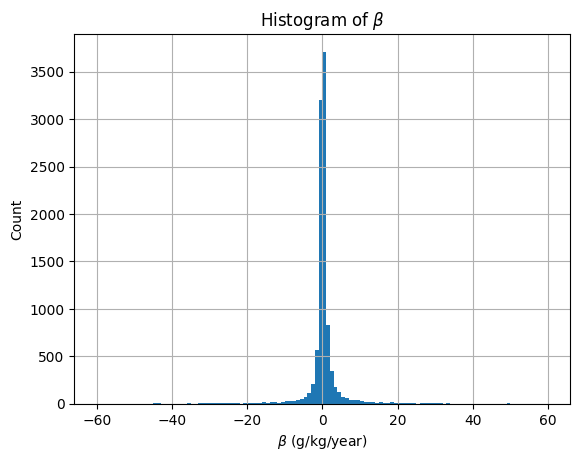

In [5]:
srs['ts_slope'].hist(bins=120,range=[-60,60])
plt.xlabel(r'$\beta$ (g/kg/year)')    
plt.ylabel('Count')  
plt.title(r'Histogram of $\beta$')  
plt.show()



3. **No evident skewness**  
   The overall distribution shows no clear skewness in either direction.  
   However, when examined in greater detail, slightly more positive $\beta$ values can be observed.


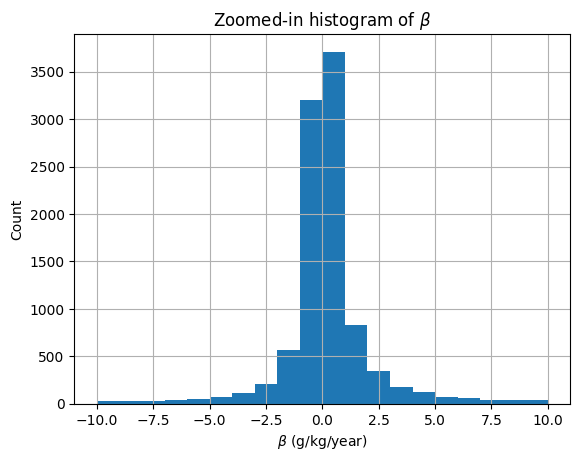

In [6]:
srs['ts_slope'].hist(bins=20,range=[-10,10])
plt.xlabel(r'$\beta$ (g/kg/year)')    
plt.ylabel('Count')  
plt.title(r'Zoomed-in histogram of $\beta$')  
plt.show()

### Distribution by land covers

1. **Unchanged land covers**  
   - Constant cropland (**CCC**) shows an almost even $\beta$ distribution.  
   - Constant grassland (**GGG**) and woodland (**WWW**) both exhibit slight positive skewness.

2. **Transitions toward reduced vegetation cover**  
   - Cropland-to-bareland (**CCB**) transitions display roughly symmetric $\beta$ distributions.  
   - Grassland-to-cropland (**GCC**) transitions show a slight negative trend.

3. **Transitions toward increased vegetation cover**  
   - Cropland-to-grassland (**CGG** and **CCG**) transitions exhibit positively skewed $\beta$ distributions.  
   - Earlier cropland-to-grassland transitions (**CGG**) show stronger positive trends compared to later ones (**CCG**).


In [7]:
srs['lc_str'] = srs['lc_survey_series'].str[0] + '-' + srs['lc_survey_series'].str[1] + '-' + srs['lc_survey_series'].str[2]
l1 = srs['lc_str'].unique().tolist()
l2 = [ii.replace('land','') for ii in l1]
map_l = dict(zip(l1,l2))
srs['lc_str'] = srs['lc_str'].map(map_l)

# only examine land cover series with population>30
vc = srs['lc_str'].value_counts()
lcl = vc[vc>30].index.tolist() 
srs = srs.loc[srs['lc_str'].isin(lcl)]

print(f'This analysis is only done on land covers with more than 30 records:')
print(lcl)

# plot in order
lc_order = [
    'crop-crop-crop', 'grass-grass-grass', 'wood-wood-wood', # no lc change
    'crop-crop-bare', 'grass-crop-crop', # decreasing veg
    'crop-grass-grass', 'crop-crop-grass' # increasing veg
]

# Set lc_str as categorical with the desired order
srs['lc_str'] = pd.Categorical(srs['lc_str'], categories=lc_order, ordered=True)

import matplotlib.patches as mpatches

# Define land cover change groups
no_change = ['crop-crop-crop', 'grass-grass-grass', 'wood-wood-wood']
decreasing = ['crop-crop-bare', 'grass-crop-crop']
increasing = ['crop-grass-grass', 'crop-crop-grass']

# Map lc_str to colors
color_map = {}
for lc in lc_order:
    if lc in no_change:
        color_map[lc] = 'olive'
    elif lc in decreasing:
        color_map[lc] = 'brown'
    elif lc in increasing:
        color_map[lc] = 'green'
    else:
        color_map[lc] = 'gray'  # fallback color

This analysis is only done on land covers with more than 30 records:
['crop-crop-crop', 'wood-wood-wood', 'grass-grass-grass', 'grass-crop-crop', 'crop-crop-bare', 'crop-crop-grass', 'crop-grass-grass', 'crop-bare-crop', 'crop-grass-crop', 'shrub-shrub-shrub', 'grass-grass-crop', 'grass-wood-wood', 'grass-crop-grass', 'bare-crop-crop', 'shrub-wood-wood', 'bare-bare-crop', 'wood-wood-grass', 'grass-shrub-shrub', 'wood-grass-wood']


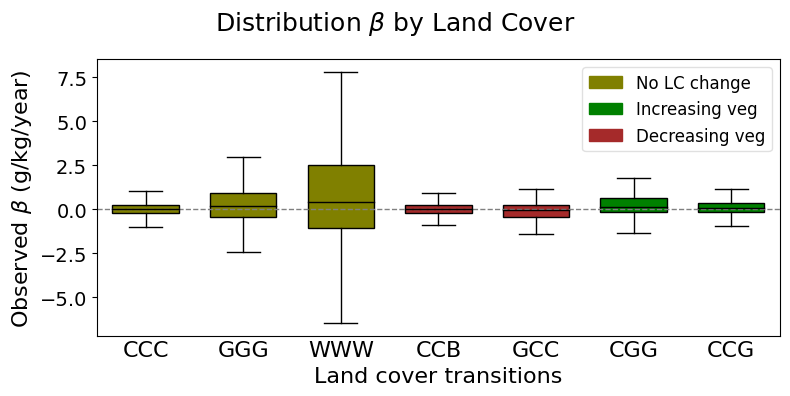

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

x = np.arange(len(lc_order))
bar_width = 0.34

signal_data = [srs.loc[srs['lc_str'] == lc, 'ts_slope'].dropna() for lc in lc_order]
bp = ax.boxplot(
    signal_data,
    positions=x,
    widths=bar_width * 2,
    showfliers=False,
    patch_artist=True,
    medianprops=dict(color='black')
)

# corlor land cover group
for box, lc in zip(bp['boxes'], lc_order):
    box.set_facecolor(color_map[lc])
    box.set_edgecolor('black')

# x label
ax.set_ylabel(r'Observed $\beta$ (g/kg/year)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)

# x tick label
ax.set_xticks(x)
ax.set_xticklabels(['CCC', 'GGG', 'WWW','CCB', 'GCC','CGG', 'CCG'],rotation=0, ha='center', fontsize=16)
ax.tick_params(axis='x', which='both', length=0)
ax.set_xlabel("Land cover transitions", fontsize=16)

# 0 line
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# lc change group
olive_patch = mpatches.Patch(color='olive', label='No LC change')
green_patch = mpatches.Patch(color='green', label='Increasing veg')
brown_patch = mpatches.Patch(color='brown', label='Decreasing veg')

ax.legend(handles=[olive_patch, green_patch, brown_patch],
          fontsize=12, framealpha=0.6, loc='upper right')
fig.suptitle(r"Distribution $\beta$ by Land Cover", fontsize=18)
plt.tight_layout()
plt.show()

